## Exercise 3

### Descrição do Problema

O objetivo deste exercício é desenvolver uma AEAD com "Tweakable Block Ciphers”", 
sendo a cifra usada do tipo AES-256 ou o ChaCha20.

Esta cifra será usada num canal privade de informação assíncrona com acordo de chaves.
A autenticação dos agentes será com:
 - “X448 key exchange”
 - “Ed448 Signing&Verification” 
 
... e deve haver uma fase de confirmação da chave acordada.


Ou seja,

Use o “package” Cryptography para
1. Implementar uma AEAD com “Tweakable Block Ciphers” conforme está descrito na última secção do texto +Capítulo 1: Primitivas Criptográficas Básicas.  A cifra por blocos primitiva, usada para gerar a “tweakable block cipher”, é o AES-256 ou o ChaCha20.
2. Use esta cifra para construir um canal privado de informação assíncrona com acordo de chaves feito com “X448 key exchange” e “Ed448 Signing&Verification” para autenticação  dos agentes. Deve incluir uma fase de confirmação da chave acordada.

In [1]:
#Imports necessários
import os
import asyncio
import random
from pickle import dumps, loads
from cryptography.hazmat.primitives.asymmetric import ec
from cryptography.hazmat.primitives import hashes, serialization
from cryptography.hazmat.primitives.asymmetric import x448, ed448
from cryptography.hazmat.primitives.kdf.hkdf import HKDF
from cryptography.hazmat.primitives.asymmetric.x448 import X448PrivateKey
from cryptography.hazmat.primitives.asymmetric.ed448 import Ed448PrivateKey
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes

# Para a porção de código associada com as queues (na comunicação entre participantes)
import nest_asyncio

nest_asyncio.apply()


import warnings
warnings.simplefilter("default") 

## Criação das chaves privadas/públicas

O acordo de chaves, como indicado no enunciado, deve ser feito com __"X448 key exchange"__.

Para tal é necessário que cada um dos agentes crie as suas próprias chaves (privada-pública).

Neste caso será usando a __curva448__, como 
apresentado na API:
- https://cryptography.io/en/latest/hazmat/primitives/asymmetric/x448/

A chave resultante será usada no decorrer da comunicação assíncrona entre agentes para __cifrar/decifrar__ os dados.

In [2]:
def generateKeys():
    # Generate private key for exchange
    prv_key = x448.X448PrivateKey.generate()
    
    # Generate public key thorugh private key
    pub_key = prv_key.public_key()
    
    return prv_key, pub_key
    

## Criação das chaves partilhadas

Após ter as chaves de cada agente (privada/pública), podemos estabelecer
o _exchange_, i.e o acordo entre ambos agentes,
sobre um segredo partilhado.

A _shared_key_ criada, tal como recomendado na API, deve ser passada por uma função de derivação, no âmbito de a tornar mais segura; adicionando mais informações à chave para destruir qualquer estrutura que possa ser criada.

Será criada uma _shared_key_, a ser usada no âmbito da cifra. 

In [3]:
def generateShared(prv_key, peer_key):
    
    peer_cipher_key = x448.X448PublicKey.from_public_bytes(peer_key)
    
    # Gerar uma chave partilha para cifra
    cipher_key = prv_key.exchange(peer_cipher_key)
    
    derived_key = HKDF(
        algorithm=hashes.SHA256(),
        length=16, #32,
        salt=None,
        info=b'handshake data',
    ).derive(cipher_key)
    
    return derived_key

## Assinar mensagem

A autenticação dos agentes é realizada com 
__“Ed448 Signing&Verification”__; sendo este um 
algoritmo de assinaturas com recurso ao __EdDSA__ (_Edwards-curve Digital Signature Algorithm_).

Para tal é necessário um novo par de chaves (privada/pública), do tipo _Ed448_, para cada um dos agentes.

Para recorrer aos meios apresentados em:
- https://cryptography.io/en/latest/hazmat/primitives/asymmetric/ed448/

As chaves públicas devem ser partilhadas por ambos, de 
modo a validar a __assinatura__ da mensagem que receberam.
Sendo a assinatura realizada através da chave privada do agente,
a enviar a mensagem.

Criou-se um método particular para gerar as chaves de autenticação dos agentes, para facilitar e tornar o código mais _readable_.

In [4]:
def generateSignKeys():
    
    ## Chave privada para assinar
    private_key = Ed448PrivateKey.generate()
    
    ## Chave pública para autenticar
    public_key = private_key.public_key()
   
    return private_key, public_key
    
def signMsg(prv_key, msg):
    
    signature = prv_key.sign(msg)
    
    return signature

## Funções auxiliares para cifragem

Os três métodos auxiliares criados, são no âmbito de:
- Adicionar padding ao _plaintext_, sendo dado o tamanho de cada bloco.

... Obtém-se o último bloco do _plaintext_, e 
preenche os restantes _bytes_ (da _lenght_ que cada bloco deve ter) 
com __0__ (neste caso _\x00_).
Retorna-se o _plaintext_ atualizado e o último bloco (_padded_).
- Executar a cifra _TPBC_ (_Tweakable Primitive Block Cipher_) num bloco;

... Recebe o _tweak_, __chave de cifra__, bloco de _plaintext_ e
o _initial_value_ (_iv_).
Optou-se pela abordagem de __expansão__ da chave de longa duração
com o _tweak_, criando a _tweaked_key_ (Concatenação da chave com o _tweak_).
Deste modo, _E(w,k,x) = E(K_x)_, sendo _w_ o _tweak_ criado, _k_ a chave de longa duração,
_x_ a mensagem a cifrar e _K_ a chave resultante da expansão (_K = w || k_).

Cifra-se o bloco do _plaintext_, utilizando a cifra num modo _CBC_ (_cipher block chaining_),
que recebe como argumento o _iv_ (sendo um modo _standard_ e mais seguros que outros, como p.e. o _ECB_).
Retorna-se, por fim, o repetivo __criptograma__.

Sendo assim, o _TPBC_ segue o esquema:
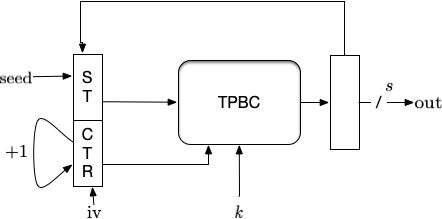

... o _tweak_ criado, como é explicado no seguinte método, correponde
à combinação da _seed + counter + bit auth_. 

- Aplicação do _TPBC_ a todos os blocos do _plaintext_ (menos o último).
... Todos os blocos, exceto o último, não são blocos de __autenticação__,
pelo que o seu _bit_ final é __0__ (definindo-se a variável _zero_ para facilitar _readability_).
Percorre-se todos os blocos do _plaintext_ (até e exceto o último),
constroi-se o respetivo _tweak_ que deve ser diferente para todos e aplica o 
método _TPBC_ em cima definido (para um bloco particular).

O _tweak_ tem o tamanho de um bloco do _plaintext_ - 16 _bytes_, sendo 
a combinação/concatenação de um _nounce_, um _counter_ (CTR) e um bit 
de autenticação.

Considerando o esquema seguinte, e o tamanho _b_ definido:
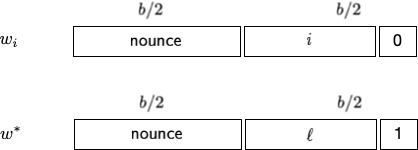

..._nounce_ - 8 _bytes_, _counter_ - 7 _bytes_ e _bit_ - 1 byte.

No final de cada iteração, para o _tweak_ variar entre cada bloco, o _counter_
é incrementado.
Para a criação da _tag_ de autenticação executa-se o _XOR_, entre a variável _auth_
e cada bloco do _plaintext_.
No final retorna-se o _counter_ e a variável _auth_ atualizados e o respetivo criptograma (dos _m-1_ primeiros blocos).

In [5]:
def pad (block_plaintext, length):
    last_block = block_plaintext[-1] # Get the last block of the list
    len_last_block = len(last_block)
    
    for _ in range (len_last_block, length): # Adds the value 0 until the size the last block is 0
        last_block += b"\x00"
    
    block_plaintext[-1] = last_block
    
    return block_plaintext, len_last_block
    
def tpbc (tweak, key, block, iv):
    tweaked_key = tweak + key
    cipher = Cipher(algorithms.AES256(tweaked_key), modes.CBC(iv))
    encryptor = cipher.encryptor()
    ct_block = encryptor.update(block) + encryptor.finalize()
    return ct_block

# nounce: bytes, ctr: bytes, block_plaintext: bytes, key: bytes, auth: bytes
def tweakable_first_blocks(nounce, ctr, block_plaintext, key, auth, iv):
    ct = b""
    zero = b"\x00"
    
    for elem in (block_plaintext[:-1]):        
        tweak = nounce + ctr + zero
        
        c_i = tpbc(tweak, key, elem, iv)
        ct += c_i
        
        len_ctr = len(ctr)
        ctr_int = int.from_bytes(ctr, 'big')
        ctr_int += 1
        ctr = ctr_int.to_bytes(len_ctr, 'big')
        
        aux = b""
        for x,y in zip(auth, elem):
            word = x ^ y
            aux += word.to_bytes(1, 'big')
        
        auth = aux
        
    return ctr, auth, ct

## Cifrar mensagem

Como indicado no enunciado, a cifra a criar para o presente 
problema tem por base _Tweakable Block Ciphers_, nomeadamente 
o modo __TAE__ (_Tweaked Authentication Encryption_), apresentado
na última parte do capítulo 1 (lecionado em aula).

Este é um modo de cifra por blocos autenticada, sem o uso de dados associados,
que recorre a _TPBC_ (_Tweaked Primitive Block Ciphers_) envês de _PBC_ (_Primitive Block Ciphers_).

Deste modo, seguiu-se o esquema apresentado:
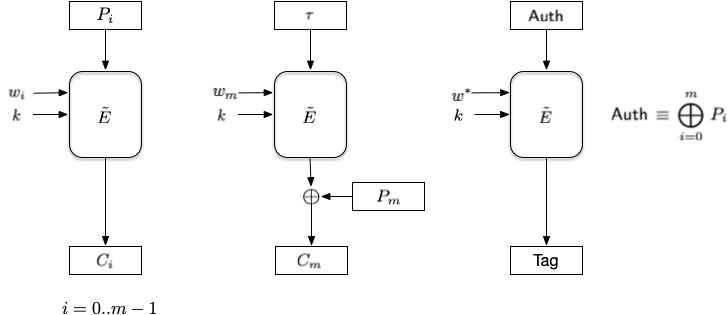

É notável que existem três processos a fazer no contexto da cifra por blocos, em modo _TAE_, e,
considerando um _plaintext_ composto por _m_ blocos, de tamanho _b_ cada, tem-se:

1. __Cifrar os primeiros _m - 1_ blocos do _plaintext___

- Os primeiro _m-1_ blocos (P_i_, t.q. _i = 0..m-1_) serão cifrados a partir da mesma chave de longa duração e de um _tweak_ único a cada bloco;
- Estes vão gerar um criptograma, _C_i_.

2. __Cifrar o último bloco _m___ 
- O últmo bloco, _m_, de tamanho _n_, t.q _n < b_, terá um _padding_ adicional no fim (_pad = b - n_), para ter tamanho b, resultando no bloco _P_m_, de tamanho _b_, em que os últimos _b - n_ bytes são zeros;
- Para cifrar o bloco é primeiro realizado um processo de cifragem no seu tamanho original _n_, utilizando a mesma chave de longa duração dos restantes _m - 1_ blocos e um _tweak_ novo (criando uma máscara);
- Por fim, é realizado um _XOR_ da máscara resultante com o último bloco _P_m_, resultando no criptograma _C_m_.

3. __Gerar uma _tag_ de autenticação a partir da paridade do _plaintext___
- Como se visualiza na imagem, a _tag_ é o resultado de cifrar os _bytes_ de autenticação.
- Estes _bytes_, _Auth_, são calculados realizando um _XOR_ por todos os _m_ blocos.
- Existirá um _byte_ de autenticação que terá valor 1, o último, sendo os restantes de valor 0, sendo estes _bytes_ os usados para o _tweak_.

---------------------------------------- Código desenvolvido ----------------------------------------

Sendo assim, o primeiro passo, após criar o _nounce_, o _counter_ e o _initial value_ a serem usados 
na cifragem com _TPBC_ (correspondendo aos tamanho inicialmente definidos - _b = 16 bytes_), 
divide-se o _plaintext_ em blocos com _NBytes_ de tamanho, na _var block_plaintext_.

Com o método:
```python
def pad(block_plaintext, length)
```
...acrescenta-se os restantes _bytes_ ao último bloco, retornando o _plaintext_ repartido atualizado e o tamanho _n_ do último bloco (_bytes_ não nulos da mensagem original).

Cria-se a variável _auth_ para ser usada na criação da _tag_.
Esta vai ser usada em processos de _XOR_, sendo uma palavra de 16 _bytes_ (zeros).

Aplica-se a cifra _TPBC_ aos primeiros _m - 1_ blocos, com o método:
```python
def tweakable_first_blocks(nounce, ctr, block_plaintext, key, auth, iv)
```
... obtendo o criptograma _C_i_, a variável de autenticação _auth_ atualizada com os _m-1_ primeiros
blocos e o _counter_ resultante.

Cria-se a máscara com os _bytes_ do último bloco, _lenght_block_, sendo criado 
o _tweak_ do mesmo modo que os outros blocos e, tal como esses,
cifrado com o método:
```python
def tpbc(tweak, key, block, iv)
```
... posteriormente é realizado o _XOR_ com o último bloco, _P_m_, criando 
o criptograma _C_m_; concatenado, por fim, ao criado inicialmente C_i_.
O criptograma encontra-se pronto.

Antes de terminar o processo, falta realizar o último _XOR_,
atualizando a variável _auth_ com o último bloco _m_.
Termina-se com a criação da _tag_ -> resultante da cifragem com o método _tpbc_
usado nos blocos do _plaintext_, com o _tweak_ semelhante (diferindo no último _byte_, de autenticação - agora é 1).

O método resultante
```python
def encrypt(msg, key)
```
retorna:
- O criptograma;
- A _tag_;
- O _nounce_;
- O _counter_ inicial (antes de ser atualizado);
- O _pad_ (tamanho dos dados do último bloco - _n_);
- E o _initial value_ usado para a cifra _CBC_.

In [6]:
def encrypt(msg, key):
    NBytes = 16; size_nounce = 8
    
    ## Nounce
    digest = hashes.Hash(hashes.SHA3_256())
    nounce_temp = digest.finalize()
    nounce = nounce_temp[:size_nounce] # array of bytes with size 8
    
    ## Counter
    ctr_i = os.urandom(size_nounce-1) # array of bytes with size 7
    ctr = ctr_i 
    
    ## Initial value for CBC
    iv = os.urandom(16)
        
    ## Partitioning plaintext into Nbytes blocks
    block_plaintext = [bytes(msg[i:i+NBytes], 'utf8') for i in range(0, len(msg), NBytes)]  # List of block of bytes. Block size 16
    
    ## Padding last block of plaintext
    block_plaintext, len_last_block = pad(block_plaintext, NBytes) # blocks de bytes de tam 16, tamanho original do ultimo bloco 
    
    # i = 0 ... m - 1    
    auth = b"" 
    for _ in range (NBytes): # array of bytes with size 16 bytes
        auth += b"\x00"
    
    ## Apply TPBC algorithm to all but last block
    ctr, auth, ct = tweakable_first_blocks(nounce, ctr, block_plaintext, key, auth, iv) # ctr: bytes; auth: str ; ct: bytes

    # i = m - TPBC on last block
    tweak = nounce + ctr +  b"\x00"
    length_block = len_last_block.to_bytes(16, 'big') # Turns the length of the last block into a 16 bytes block
    c_aux = tpbc(tweak, key, length_block, iv) # c_aux: bytes
    
    c_m = b""
    for x,y in zip(block_plaintext[-1], c_aux):
        word = x ^ y
        c_m += word.to_bytes(1, 'big')
        
    ## Concatenating last block c_m to the rest of the cipher 
    ct += c_m # ct: bytes
    
    aux = b""
    for x,y in zip(auth, block_plaintext[-1]):
        word = x ^ y
        aux += word.to_bytes(1, 'big')
    auth = aux
    
    ## Autenticação - Criar a tag para autenticação
    tweak = nounce + ctr + b"\x01"
    tag = tpbc(tweak, key, auth, iv)
    
    return {"ct": ct, "tag": tag, "nounce": nounce, "ctr": ctr_i, "pad": len_last_block, "iv": iv}

## Funções auxiliares para decifragem

As funções criadas para a decifragem da mensagem são o inverso
das criadas em cima, para a cifragem.

Neste sentido, tem-se:

1. Eliminação do _bytes_ de _padding_ do último bloco do _plaintext_;
2. A decifragem (do _CBC_) de um único bloco, utilizando o _tweak_ e o _initial value_ usados para cifrar;
3. A decifragem dos primeiros (_m - 1_) blocos, utilizando o método em __2.__.

... para o ponto __3.__, ainda tem-se a atualização do valor do _counter_ e da var _auth_ (exatamente como no processo de cifra), retornando-os.

In [7]:
# size_block = tau
def unpad(last_block, size_block, NBytes):
    
    last_block = last_block[:size_block]
    
    return last_block

def un_tpbc(tweak, key, block, iv):
    tweaked_key = tweak + key
    cipher = Cipher(algorithms.AES256(tweaked_key), modes.CBC(iv))
    decryptor = cipher.decryptor()
    plain_block = decryptor.update(block) + decryptor.finalize()
    return plain_block

def undo_tweakable_first_blocks(nounce, ctr, block_ciphertext, key, auth, iv):
    plaintext = b""    
    for elem in (block_ciphertext[:-1]):        
        tweak = nounce + ctr +  b"\x00"
        
        c_i = un_tpbc(tweak, key, elem, iv)
        plaintext += c_i
        
        len_ctr = len(ctr)
        ctr_int = int.from_bytes(ctr, 'big')
        ctr_int += 1
        ctr = ctr_int.to_bytes(len_ctr, 'big')
        
        aux = b""
        for x,y in zip(auth, c_i):
            word = x ^ y
            aux += word.to_bytes(1, 'big')
        
        auth = aux
        
    return ctr, auth, plaintext



## Decifrar mensagem

O processo de decifragem, à semelhança das suas funções auxiliares definidas em cima,
trata-se do processo __reverso__ do que foi efetuado no âmbito da cifra.

1. Reparte-se o _plaintext_ em blocos, com o tamanho originalmente usado - 16 _bytes_;

2. Decifra-se os primeiros _m-1_ blocos;

3. Decifra-se o último bloco, _m_;

4. Obtém-se o _plaintext (através da concatenação dos _m-1_ blocos com o _m_);

5. Recria-se a autenticação (com a criação da _tag_);

...A autenticação é exatamente do mesmo modo que na cifra, para 
no final comparar as _tags_ resultantes.
Envia-se um _booleano_ para indicar se o processo foi feito com sucesso
ou se sofreu repercussões, na forma da variável _tag_valid_.

In [8]:
def decrypt(msg, key):
    ct = msg['ct'] # bytes
    tag_rcv = msg['tag']
    nounce = msg['nounce']
    ctr = msg['ctr']
    len_last_block = msg['pad']
    iv = msg['iv']
    
    NBytes = 16
    
    block_ciphertext = [ct[i:i+NBytes] for i in range(0, len(ct), NBytes)]  # list of block of bytes. Block size 16 bytes
    
    # i= 0 ... m - 1
    auth = b"" 
    for _ in range (NBytes): # array of bytes with size 16 bytes
        auth += b"\x00"
    ctr, auth, plaintext = undo_tweakable_first_blocks(nounce, ctr, block_ciphertext, key, auth, iv)
        
    # i = m
    tweak = nounce + ctr + b"\x00"
    length_block = len_last_block.to_bytes(16, 'big')
    c_aux = tpbc(tweak, key, length_block, iv)
    
    c_m = b""
    for x,y in zip(block_ciphertext[-1], c_aux):
        word = x ^ y
        c_m += word.to_bytes(1, 'big')
    
    plaintext += c_m[:len_last_block] # ct: bytes
    
    aux = b""
    for x,y in zip(auth, c_m):
        word = x ^ y
        aux += word.to_bytes(1, 'big')
    auth = aux
    
    # Autenticação
    tweak = nounce + ctr + b"\x01"
    
    tag = tpbc(tweak, key, auth, iv)
    
    tag_valid = True
    if tag != tag_rcv:
        tag_valid = False
        
    return plaintext, tag_valid

## Funções auxiliares para o canal de comunicação
Encontra-se 3 métodos auxiliares para:
- inicialização dos agentes;
- Envio de mensagens;
- Receção de mensagem.

Os métodos para envio e receção de mensagens
têm em consideração o código proporcionado
pela equipa docente, em consideração das 
estruturas _queues_.

O método para __inicialização__:
- Cria os dois pares de chaves pública-privada (para cifrar e assinar);
- Serializa as chaves públicas (para enviar ao _peer_);
- Retorna um tuplo com as chaves e o pacote a enviar ao peer.

...com o nome _init_comm().

É realizada uma __assinatura da chave pública para cifrar__ à priori, correpondendo
à fase de __confirmação da chave acordada__.
Uma vez que esta é uma chave temporária, e usada unicamente para confirmar que a assinatura
está correta, não inclui tantas informações para a tornar mais crédula; por exemplo
certificados, protocolos, etc...

Sendo assim, a fase de confirmação desta chave de __curta duração__ é, essencialmente,
a criação de uma assinatura para a avaliar ao ser enviada ao respetivo _peer_.

In [9]:
def init_comm():
    ## Gerar chaves (cifrar e autenticar)
    prv_cipher_key, pub_cipher_key = generateKeys()
    
    prv_sign_key, pub_sign_key = generateSignKeys()
    
    msg_to_sign = pub_cipher_key.public_bytes(encoding=serialization.Encoding.Raw,
                                       format=serialization.PublicFormat.Raw
                                    )
    
    ##Assinar a public cipher key - autenticação da chave acordada
    sign = signMsg(prv_sign_key, msg_to_sign)
    
    ## Dicionário com a chavess públicas (serializadas)
    msg = {'cipher_key': pub_cipher_key.public_bytes(encoding=serialization.Encoding.Raw,
                                       format=serialization.PublicFormat.Raw
                                    ), 
           'sign_key': pub_sign_key.public_bytes(encoding=serialization.Encoding.Raw,
                                       format=serialization.PublicFormat.Raw
                                    ),
           'sig': sign
            }
    
    return prv_cipher_key, prv_sign_key, msg

async def send(queue, msg):
    
    await asyncio.sleep(random.random())
        
    # put the item in the queue
    await queue.put(msg)
    
    await asyncio.sleep(random.random())
    
async def receive(queue):
    item = await queue.get()

    await asyncio.sleep(random.random())
    aux = loads(item)

    return aux

## Emitter

O processo do _emitter_ passa pelos passos:

- Criar dois pares de chaves privadas/públicas (para __cifrar__ e __assinar__);
- Assinar a chave pública de cifragem (com a chave privada de assinar);
- Enviar as chaves públicas (de cifragem e para verificar a assinatura);
- Receber as respetivas chaves públicas do peer (e a assinatura);
- Validar a assinatura;
- Gerar o segredo partilhado para cifragem (chave partilhada - _cipher_)
- Cifrar a mensagem com a chave partilhada (_encrypt_)
- Assinar com a chave privada (para assinar)
- Enviar pacote para o _receiver_

In [10]:
## Emitter Code
async def emitter(plaintext, queue):
    
    ## Gerar as chaves (privada e publica) & partilhar com participante
    prv_cipher_key, prv_sign_key, msg = init_comm()
    
    ## Enviar a chaves públicas para o peer
    print("[E] SENDING PUBLIC KEYS")
    await send(queue, dumps(msg))
    
    ## Receber as chaves públicas do peer
    msg = await receive(queue)
    print("[E] RECEIVED PEER PUBLIC KEYS")
    
    pub_peer_cipher = msg['cipher_key']
    pub_peer_sign = msg['sign_key']
    signature = msg['sig']
    print("[E] Receiver pub_key_cipher: " +str(pub_peer_cipher))
    print("[E] Receiver pub_key_sign: " +str(pub_peer_sign))
    print("[E] Receiver signature: " +str(signature))
    
    try:
        ## Obter a chave pública (Assinatura)
        peer_sign_pubkey = ed448.Ed448PublicKey.from_public_bytes(pub_peer_sign)
        
        ## Verificar a assinatura da chave pública
        peer_sign_pubkey.verify(signature, pub_peer_cipher)
        print("[E] SIGNATURE VALIDATED")
        
        ## Criar as chaves partilhadas (cifrar/autenticar)
        cipher_shared = generateShared(prv_cipher_key, pub_peer_cipher)

        print("[E] CIPHER SHARED: "+str(cipher_shared))

        ## Cifrar a mensagem
        pkg = encrypt(plaintext, cipher_shared)
        print("[E] MESSAGE ENCRYPTED")

        ## Assinar e enviar a mensagem
        pkg_b = dumps(pkg)
        sig = signMsg(prv_sign_key, pkg_b)

        ## a Enviar...
        msg_final = {'sig': sig, 'msg': dumps(pkg)}

        print("[E] SENDING MESSAGE")
        await send(queue, dumps(msg_final))

        print("[E] END")
        
    except InvalidSignature:
        printf("A assinatura não foi verificada com sucesso!")

## Receiver

Os dois agentes, no contexto deste exemplo, são particularmente 
semelhantes, apenas só alterando a ordem dos eventos. Neste caso,
é do _emitter_ para o _receiver_.

Sendo assim, os eventos surgem como:
- Criar dois pares de chaves privadas/públicas (para cifrar e assinar);
- Receber as respetivas chaves públicas do peer (e a assinatura);
- Validar a assinatura da chave pública de cifra;
- Gerar o segredo partilhado para cifragem (chave partilhada - _cipher_);
- Enviar as chaves públicas (de cifragem e para verificar a assinatura);
- Receber o criptograma do _emitter_;
- Validar a assinatura do criptograma;
- Decifrar o pacote e obter o _plain_text_;
- Imprimir o _plaintext_.

In [11]:
## Receiver Code
async def receiver(queue):
    
    ## Gerar as chaves (privada e publica) & partilhar com participante
    prv_cipher_key, prv_sign_key, msg = init_comm()
    
    ## Receber as chaves publicas do peer
    pub_keys = await receive(queue)
    
    pub_peer_cipher = pub_keys['cipher_key']
    pub_peer_sign = pub_keys['sign_key']
    signature = pub_keys['sig']
    print("[R] Emitter pub_key_cipher: " +str(pub_peer_cipher))
    print("[R] Emitter pub_key_sign: " +str(pub_peer_sign))
    print("[R] Receiver signature: " +str(signature))
    
    try:
        ## Obter a chave pública (Assinatura)
        peer_sign_pubkey = ed448.Ed448PublicKey.from_public_bytes(pub_peer_sign)
        
        ## Validar a correçaõ da assinatura
        peer_sign_pubkey.verify(signature, pub_peer_cipher)
        print("[R] SIGNATURE VALIDATED")
        
        ## Gerar shared keys
        cipher_shared = generateShared(prv_cipher_key, pub_peer_cipher)

        ## Enviar as chaves públicas ao peer
        print("[R] SEND PUBLIC KEYS")
        await send(queue, dumps(msg))
        
        ## Receber criptograma
        print("[R] AWAIT CIPHER")
        ciphertext = await receive(queue)
        print("[R] CIPHER RECEIVED")

        try:     
            ## Validar a correção da assinatura
            peer_sign_pubkey.verify(ciphertext['sig'], ciphertext['msg'])
            print("[R] SIGNATURE VALIDATED")

            msg_dict = loads(ciphertext['msg'])

            ## Decifrar essa mensagem       
            plain_text, tag_valid = decrypt(msg_dict, cipher_shared)
            
            if tag_valid == False:
                print("Autenticação falhada!")
                return 
            
            print("[R] MESSAGE DECRYPTED")

            ## Apresentar no terminal
            print("[R] PLAINTEXT: " + plain_text.decode('utf-8'))

            print("[R] END")

        except InvalidSignature:
            print("The signature wasn't validated correctly! - Cipher")
            
    except InvalidSignature:
        print("The signature wasn't validated correctly! - Cipher key")

## Teste de execução

Encontra-se na célula abaixo um exemplo de execução
da comunicação entre um _emitter_ e um _receiver_,
acompanhada das respetivas autenticações do agentes, da mensagem,
bem como a cifragem/decifragem da última.

O método:
```python
def test(msg)
```

... funciona como um método _main_ para a execução; recebendo
como argumento a __mensagem__.

In [12]:
def test(msg):
    loop = asyncio.get_event_loop()
    queue = asyncio.Queue(10)
    asyncio.ensure_future(emitter(msg, queue), loop=loop)
    loop.run_until_complete(receiver(queue))
    
test("HELLO WORLD! THIS IS JUST A TEST OF A AEAD ALGORITHM.")

[E] SENDING PUBLIC KEYS
[R] Emitter pub_key_cipher: b'\xbd?3\xcf\x1d:\xd4\r~Y\xe5;\xa0\xcb\x19\xe7 |k6Y`\x13h\xfc\xd5`\xab\xc3\xfe\xf7S\xfcw"\xab\xc6V+n\xd7\x9dh\xe6%c\x93\x93\x0c\xd3\x7f\x12\x97\xb5M\xde'
[R] Emitter pub_key_sign: b'\xaf\xd6\xc8\xddAE\xc6\xdev#\xf7gh!d\x8dp\xe0\x88\x1c\xf7\x93E\xc7\x07\xc4\xa5&nZ\xb8Gz\xf1O\xa5(%\xc5\x0e\xa2\xdb\xee%vj\x19)g\xf5a\xd5W\x1d\xba \x00'
[R] Receiver signature: b"\x10\x9e\x97U\xda\xc0o\xe9\x90p'\xc6\xd8@e\xef\xbd\x85\xe9\xce6\xa7nI\xf4m1\x19\x17\x13\xd4\xd7\xe8\xbf\xd5pH\xbc2\xd4\xf4\x9f\x9e\xaa#\t=\x89\x08\xbd\xa3hc'O\xd4\x00\xc7O\xfdN\xd4\xd5\x83\xcb\xfc)K\xcb=!vmb\xb4m\xef\xb0\x87\xe6\\\xbc\x0b{\x03@^\x05\xec\x03\xaf\x14\x03\\\xce\xec\xe6\x8c\xb9\xe3-\x85\xfe\x1c,\x8d\xdf\xd4\xd2\x8b\x87%7\x00"
[R] SIGNATURE VALIDATED
[R] SEND PUBLIC KEYS
[R] AWAIT CIPHER
[E] RECEIVED PEER PUBLIC KEYS
[E] Receiver pub_key_cipher: b'\x0e\xcb\xaf\xae91\xec\x07\xb7\xf6m{\xc3\xdcu\xdd\xac?\xd2\x90\xfc\x9e3\x8c\x8e9a\x19\xe1\x1a:d\xc3\x9e\xf9\xc8t\x8dv\xf4\xa

## Outro teste de execução

Neste é apresentada a possibilidade de se inserir um _input_ do utilizador,
como mensagem a ser enviada do _emitter_ para o _receiver_, 
a passar pela cifra.

In [13]:
msg = input()

test(msg)

 HELLO WORLD


[E] SENDING PUBLIC KEYS
[R] Emitter pub_key_cipher: b"i\xaa%'\xa3\x06?\xc2\xd8\xddi\xf9<\x98o\xf2\xbf\x16T\x8b\xc4j\x16\xf6\xaa\x8c\xd8\x94\x1d\x18\xa5\xdd\xa6\xd3\xbc\x8c\xf7\x89\x01+\x86\x0e:\x04%\xa8\x13LH\xa3w\xdeL\xddw~"
[R] Emitter pub_key_sign: b'\xc9\xb6cE\x8e\x94L\xdb\x00\x17\x7f\x0b\x8f\xa0A\x90\x94\xd3\xa6\xbf\xcc\xe4\r\xcd \xe9\x1a\x1bR\xcf\xd0$\xce\rm(\xe2[\xf34P\x05;U\xc2\xf2S\x8c\xa8\xf8\x0c\x19\xabF\x87\xa2\x00'
[R] Receiver signature: b'\xdb\x00\xacrx\xc3\xca\x1f\x87;e\xb2\xbbH\x81+\xb2q\xca\x14a\x96\xce\xa5\x02@/\\\xb5\x878Xm\x8bh\xe3\x11\xd6\xc1\xef\xe7\x0e>\x16\x89\xca-(\x9b\x80\xad;\xbd\x83g\x04\x80\xb8\xe9/?T\xce\x14\x16\xf1\xf62\x0e\xc6\xe7)\xddK\x17|\x961h\x14\x92\x04\xe6&\x13vS\xee5v\xb6\xb8\x9df\xb34\xe2\xe0\xaeV=B\xda\xe0(7 \x88\x99\x8f\xe5\xec"\x00'
[R] SIGNATURE VALIDATED
[R] SEND PUBLIC KEYS
[E] RECEIVED PEER PUBLIC KEYS
[E] Receiver pub_key_cipher: b'1\xe1]\r:q)\xba\xa0o\xe3\xaa\xde\x83=\xf7\xf0\xe8\x19\xb6\x02;\xd2\xa9\xbb\xff\xbd\x08\xcc\xde\x07A\x84\xd